In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
%matplotlib inline
plt.style.use('ggplot') 
# Create a database connection
user = 'biggeo'
host = 'localhost'
dbname = 'mimic'
schema = 'mimiciii'
pwd = '******'
# Connect to the database
con = psycopg2.connect(dbname=dbname, user=user, host=host, 
                       password=pwd)
cur = con.cursor()
cur.execute('SET search_path to {}'.format(schema))



Bad key "text.kerning_factor" on line 4 in
/Users/geombpro/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
#prepare data frame
query_TBI_ML = \
"""
SELECT  

/*COUNT( distinct ad.hadm_id)*/
		pa.gender,
		(DATE_PART('year', ad.admittime::date) - DATE_PART('year', pa.dob::date)) AS age,
		ad.diagnosis,
		ad.hadm_id,
/*		ad.admittime,
		ad.dischtime,
		icu.icustay_id,*/
		gcs.gcs,
        DATE_PART('day', ne.charttime::timestamp - ad.admittime::timestamp) * 24 + 
              DATE_PART('hour', ne.charttime::timestamp - ad.admittime::timestamp) AS chartdelayhrs,
/*		ne.description,
		ne.text,*/
		d.icd9_code,
		ad.hospital_expire_flag   
FROM mimiciii.admissions AS ad
INNER JOIN mimiciii.icustays AS icu ON ad.hadm_id = icu.hadm_id
INNER JOIN mimiciii.pivoted_gcs AS gcs ON icu.icustay_id = gcs.icustay_id
INNER JOIN mimiciii.noteevents AS ne ON ne.hadm_id = ad.hadm_id
INNER JOIN mimiciii.diagnoses_icd AS d ON d.hadm_id = ad.hadm_id
INNER JOIN mimiciii.patients AS pa ON pa.subject_id = ad.subject_id
WHERE 	
		
/*		(gcs.gcs >= 13 
		AND gcs.gcs <= 15)
		AND */
		lower(ne.description) like '%ct head%' 
		AND 
		(
			(d.icd9_code >= '8010' 
			AND d.icd9_code < '8019')
		OR 
			(d.icd9_code >= '8030' 
			AND d.icd9_code < '8049')
		OR
			(d.icd9_code >= '85' 
			AND d.icd9_code < '8541')
		OR
			(d.icd9_code >= '951' 
			AND d.icd9_code < '953')
		OR
			d.icd9_code IN ('95555', '95901')
		)
/*		AND ad.hospital_expire_flag = 1 */

 
"""
data_TBI_ML = pd.read_sql_query(query_TBI_ML,con)
#data_TBI = pd.DataFrame(data_TBI)
#data_TBI.fillna({'label':'Other', 'flag':'normal'}, inplace=True)
data_TBI_ML.drop_duplicates(inplace = True)
#remove negative delay rows
data_TBI_ML.drop(data_TBI_ML[data_TBI_ML.chartdelayhrs <0].index, inplace=True)
#remove hadm_id
data_TBI_ML.drop(['hadm_id'], axis=1, inplace=True)
print("total data:\n", data_TBI_ML.describe())

data_TBI_ML.head()


total data:
                 age           gcs  chartdelayhrs  hospital_expire_flag
count  20458.000000  20458.000000   20458.000000          20458.000000
mean      76.133542     11.791426     100.025907              0.139750
std       65.435214      3.176198     154.139733              0.346736
min       16.000000      3.000000       0.000000              0.000000
25%       44.000000     10.000000      11.000000              0.000000
50%       65.000000     13.000000      37.000000              0.000000
75%       80.000000     15.000000     124.000000              0.000000
max      306.000000     15.000000    1216.000000              1.000000


,gender,age,diagnosis,gcs,chartdelayhrs,icd9_code,hospital_expire_flag
1,F,82.0,HEAD BLEED,14.0,19.0,85220,0
4,F,82.0,HEAD BLEED,15.0,19.0,85220,0
12,M,62.0,BLUNT TRAUMA,15.0,261.0,80130,0
70,F,81.0,ACUTE SUBDURAL HEMATOMA,15.0,5.0,85221,0
71,F,81.0,ACUTE SUBDURAL HEMATOMA,15.0,37.0,85221,0


In [382]:
#data_TBI_ML.to_csv("TBI_ML.csv", index=False)

In [383]:
#data_TBI_ML = pd.read_csv("TBI_ML.csv", index_col=0)
#data_TBI_ML.head()

In [384]:
#data_unique is to query all unique value for categorical columns, to avoid error in imputation
# data_unique | yu (786 rows)
# data_TBI_ML -> do test_valid split (70-30)
# test (2000 rows)
# Then add data_unique back into train data, not valid data
data_unique = pd.DataFrame()
for i in data_TBI_ML['diagnosis'].unique():
    criteria = "diagnosis == \"" + i +"\""
    data_unique = pd.concat([data_unique,(data_TBI_ML.query(criteria).head(1))])
for j in data_TBI_ML['icd9_code'].unique():
    criteria = "icd9_code == \"" + j +"\""
    data_unique = pd.concat([data_unique,(data_TBI_ML.query(criteria).head(1))])
#print("data unique:\n",data_unique.describe())

data_TBI_ML.drop(data_unique.index, inplace=True)
#data_TBI_ML.describe()
test = data_TBI_ML.sample(n=2000)
#test.describe()
data_TBI_ML.drop(test.index, inplace=True)
#data_TBI_ML.describe()

In [385]:
# Remove rows with missing target, separate target from predictors

X=data_TBI_ML
y = X.hospital_expire_flag
X.drop(['hospital_expire_flag'], axis=1, inplace=True)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3,
                                                      random_state=0)

#add unique set to the top of training set

yu = data_unique.hospital_expire_flag
data_unique.drop(['hospital_expire_flag'], axis=1, inplace=True)

X_train = pd.concat([data_unique, X_train])
y_train = pd.concat([yu, y_train])
#X_train.head()
#X_valid.head()

In [386]:
#no missing value
#missing_val_count_by_column = (X_train.isnull().sum())
#print(missing_val_count_by_column[missing_val_count_by_column > 0])


In [387]:
#cols_with_missing = [col for col in X_train.columns if X_train[col].isnull().any()]
# Fill in the lines below: drop columns in training and validation data
#reduced_X_train = X_train.drop(['Cabin','Embarked','Name', 'Ticket'], axis = 1)
#reduced_X_valid = X_valid.drop(['Cabin','Embarked','Name', 'Ticket'], axis = 1)
#reduced_X_test = X_test.drop(['Cabin','Embarked','Name', 'Ticket'], axis = 1)

In [388]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['gender', 'diagnosis', 'icd9_code']


In [389]:
tt = test
y_test = tt.hospital_expire_flag
X_test = tt.drop(['hospital_expire_flag'], axis=1)
X_test.head()

,gender,age,diagnosis,gcs,chartdelayhrs,icd9_code
150886,M,23.0,MULTIPLE TRAUMA,15.0,1073.0,80141
164077,M,60.0,S/P FALL,15.0,185.0,80120
555281,F,85.0,INTRACRANIAL HEMORRHAGE,13.0,1.0,85220
71961,F,44.0,S/P FALL;DROWNING,12.0,42.0,80336
64865,F,85.0,SUBARACHNOID,13.0,90.0,85221


In [390]:
#data_tr_val = pd.concat([data_unique, data_TBI_ML])
#X = data_tr_val.reset_index()
#tt = test.reset_index()



In [391]:
from sklearn.preprocessing import LabelEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()
label_X_test = X_test.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_X_train[col] = label_encoder.fit_transform(X_train[col])
    label_X_valid[col] = label_encoder.transform(X_valid[col])
    label_X_test[col] = label_encoder.transform(X_test[col])

#print("MAE from Approach 2 (Label Encoding):") 
#print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

In [392]:
from sklearn.impute import SimpleImputer

# Fill in the lines below: imputation
 # Your code here
# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(label_X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(label_X_valid))
imputed_X_test = pd.DataFrame(my_imputer.transform(label_X_test))

# Imputation removed column names; put them back
imputed_X_train.columns = label_X_train.columns
imputed_X_valid.columns = label_X_valid.columns
imputed_X_test.columns = label_X_test.columns

In [413]:
# data analysis and wrangling
import numpy as np
import random as rnd

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix




# Function for comparing different approaches
from sklearn import model_selection


model = RandomForestClassifier(n_estimators=200, random_state=0)

#model = DecisionTreeClassifier()

model.fit(imputed_X_train, y_train)
preds = model.predict(imputed_X_valid)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_valid, preds.round()))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_valid, preds.round()))
print('\n')

print("=== Model Score ===")
    
print(round(model.score(imputed_X_valid, y_valid) * 100, 2))




=== Confusion Matrix ===
[[4568    9]
 [  61  687]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4577
           1       0.99      0.92      0.95       748

    accuracy                           0.99      5325
   macro avg       0.99      0.96      0.97      5325
weighted avg       0.99      0.99      0.99      5325



=== Model Score ===
98.69


In [415]:
model.feature_importances_

array([0.03422624, 0.26665885, 0.25361925, 0.0767454 , 0.13740596,
       0.2313443 ])

Feature: gender, 	 Score: 0.03423
Feature: age, 	 Score: 0.26666
Feature: diagnosis, 	 Score: 0.25362
Feature: gcs, 	 Score: 0.07675
Feature: chartdelayhrs, 	 Score: 0.13741
Feature: icd9_code, 	 Score: 0.23134


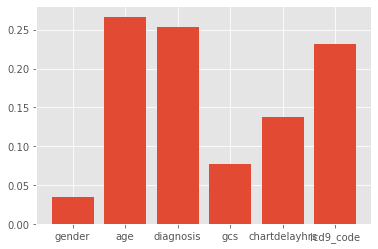

In [409]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0s, \t Score: %.5f' % (imputed_X_valid.columns[i],v))
# plot feature importance
pyplot.bar([imputed_X_valid.columns[x] for x in range(len(importance))], importance)
pyplot.show()

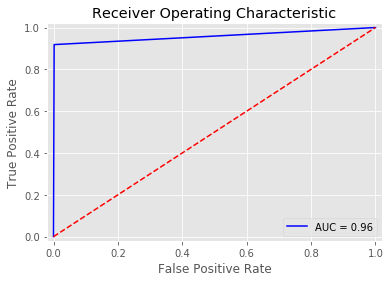

"# method II: ggplot\nfrom ggplot import *\ndf = pd.DataFrame(dict(fpr = fpr, tpr = tpr))\nggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')"

In [410]:
import scikitplot as skplt
import matplotlib.pyplot as plt



import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
#probs = preds
#preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_valid, preds.round())
roc_auc = metrics.auc(fpr, tpr)


# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


'''# method II: ggplot
from ggplot import *
df = pd.DataFrame(dict(fpr = fpr, tpr = tpr))
ggplot(df, aes(x = 'fpr', y = 'tpr')) + geom_line() + geom_abline(linetype = 'dashed')'''

/Users/geombpro/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/geombpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/geombpro/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO.

LR: 0.772129 (0.052097)
LDA: 0.773462 (0.051592)
KNN: 0.726555 (0.061821)
CART: 0.692601 (0.058479)
NB: 0.755178 (0.042766)
SVM: 0.760424 (0.052931)


/Users/geombpro/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/geombpro/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/geombpro/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/Users/geombpro/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a ran

RF: 0.772078 (0.065269)


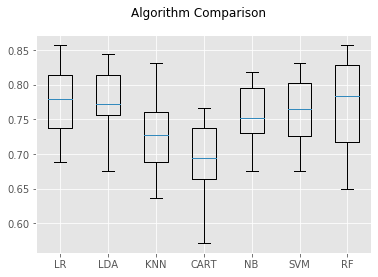

In [411]:

# Compare Algorithms
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
